# Milo - KNN based differential abundance analysis  

### Spatial pancreas data using nPOD annotation

Many biological conditions (disease, development, genetic KOs) can induce shifts in cell composition, where cells of a given state become enriched or depleted in response to a perturbation. With differential abundance analysis, we quantify consistent changes in cell composition across replicate samples. While differential abundance analysis can be performed on cell type clusters, it’s not always possible or practical to use precisely labeled clusters, especially when we are interested in studying transitional states, such as during developmental processes, or when we expect only a subpopulation of a cell type to be affected by the condition of interest. [Milo](https://doi.org/10.1038/s41587-021-01033-z) is a method to detect compositional changes occurring in smaller subpopulations of cells, defined as neighbourhoods over the k-nearest neighbor (KNN) graph of cell-cell similarities.

### Pre-requisites

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np

import scanpy as sc
import pertpy as pt
import squidpy as sq

import matplotlib
import matplotlib.pyplot as plt

sc.settings.verbosity = 3

/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [25]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
adata = sc.read(folder+'merged_slides_npod_annotation_filtered.h5ad')
adata

/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 386727 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
    uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'neighbors', 'pca', 'spatial'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'
    layers: 'counts'

### Data Exploration

This object collects spatial data from pancreas of 6 individuals profiled in 3 slides

In [26]:
x = pd.crosstab(adata.obs.condition,adata.obs.slide)
x

slide,Run5211_S1,Run5211_S2,Run5211_S3
condition,,,
ND,61460,48614,51365
T1D,47251,77807,100230


The labels aren't in the same order explored in the draft, let's reorder them for easier comparison

In [27]:
adata.obs.CellTypes_max.cat.categories, #adata.obs.niche_label.cat.categories

(Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal',
        'Activated_Stellate', 'Alpha', 'Beta', 'Delta', 'Ductal', 'Endothelial',
        'MUC5b_Ductal', 'Macrophage', 'Quiescent_Stellate', 'Tcells'],
       dtype='object'),)

In [28]:
# Define the new order of cell type categories
new_order = ['Acinar_basal', 'Acinar_highEnz','Acinar_signal','Acinar_sigdiff',
            'Ductal','MUC5b_Ductal','Beta','Alpha','Delta','Activated_Stellate',
            'Quiescent_Stellate','Endothelial','Macrophage','Tcells']

# Reorder cell type categories
adata.obs['CellTypes_max'] = adata.obs['CellTypes_max'].cat.reorder_categories(new_order, ordered=True)


# Fix color paletes 
adata.uns['CellTypes_max_colors'] = [
    '#4FB3AA', '#005F73', '#5FD3CF', '#0A9396', '#bde0fe', '#6096ba', '#ffd6ff', 
    '#b5838d', '#c8b6ff', '#e07a5f', '#ff7f51', '#f2cc8f', '#8d0801', '#e5383b',
] 

In [ ]:
# Define the new order of niche label categories
new_order = ['Niche_1', 'Niche_2', 'Niche_3', 'Niche_4', 'Niche_5',
             'Niche_6', 'Niche_7', 'Niche_8', 'Niche_9', 'Niche_10']

# Reorder niche label categories
adata.obs['niche_label'] = adata.obs['niche_label'].cat.reorder_categories(new_order, ordered=True)

adata.uns['niche_label_colors']  = [
    '#0A3D42', '#1a767f', '#73B2B9', '#CBEEF3', '#9D9D9C',
    '#595CFF', '#100BAC', '#71C6CE', '#A0EB0A', '#FFED66',
] 

In [29]:
x = pd.crosstab(adata.obs.CellTypes_max,adata.obs.condition)
x

condition,ND,T1D
CellTypes_max,,
Acinar_basal,16088,17416
Acinar_highEnz,27414,38041
Acinar_signal,13944,18322
Acinar_sigdiff,27579,42974
Ductal,21953,34525
MUC5b_Ductal,4340,6307
Beta,7557,6754
Alpha,8789,10014
Delta,3246,4046


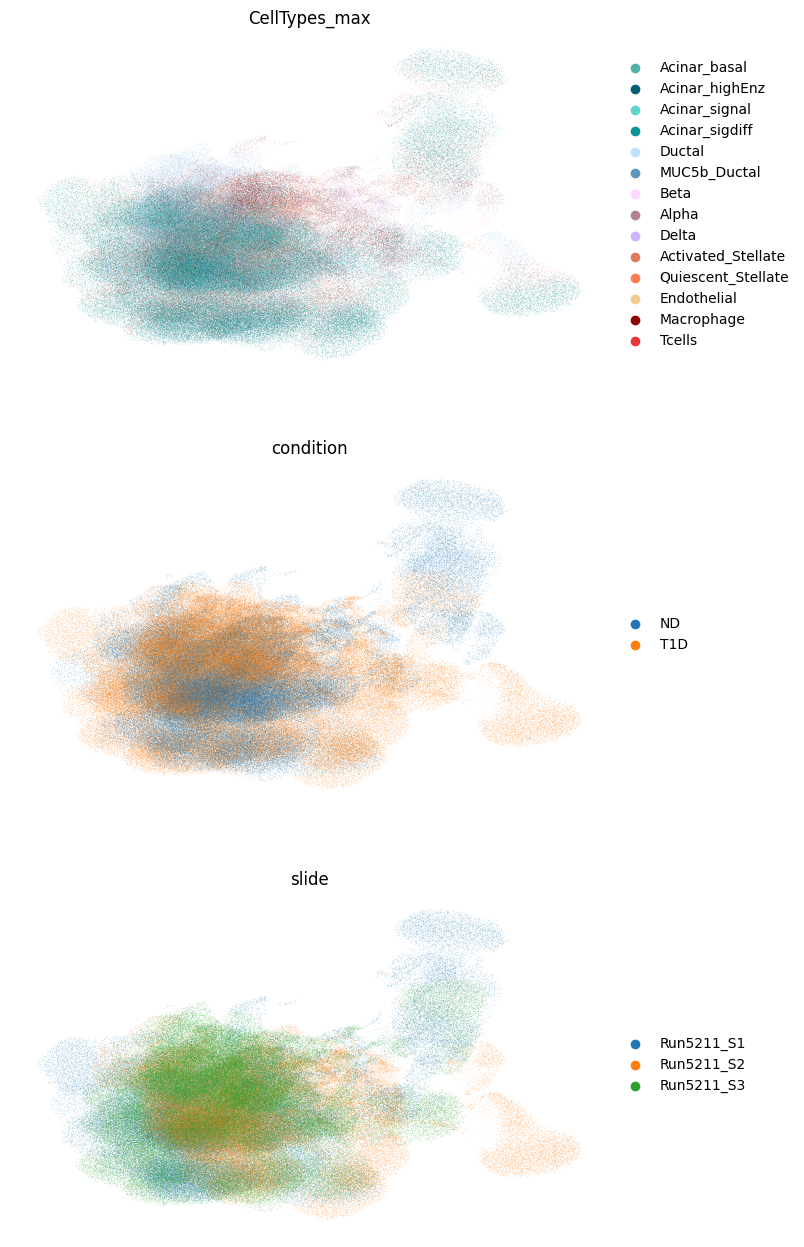

In [30]:
sc.pl.umap(adata, color=['CellTypes_max','condition','slide'], wspace=0.3,
          frameon=False, ncols=1)

We see there's no nice integration of the counts, this is expected as we haven't performed any integration method. We'll test two approaches:  
1. test milo on spatial graphs -> don't really work because need graphs with mixed conditions, if considering spatial graphs per fov, each graph is limited to a condition and a sample.
2. test milo on knn graph with prior integration

### Integration using scVI tools and scANVI

In [31]:
import scvi
import seaborn as sns
import torch
from rich import print
#from scib_metrics.benchmark import Benchmarker

In [33]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="slide",
    subset=True,
)
adata

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 386727 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'neighbors', 'pca', 'spatial', 'condition_colors', 'slide_colors', 'hvg'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'
    layers: 'counts'

#### scVI

In [45]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="condition")

In [46]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [47]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 21/21: 100%|██████████| 21/21 [07:39<00:00, 21.97s/it, v_num=1, train_loss_step=368, train_loss_epoch=277]

`Trainer.fit` stopped: `max_epochs=21` reached.


Epoch 21/21: 100%|██████████| 21/21 [07:39<00:00, 21.89s/it, v_num=1, train_loss_step=368, train_loss_epoch=277]


In [48]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [49]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:23)


In [50]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:46)


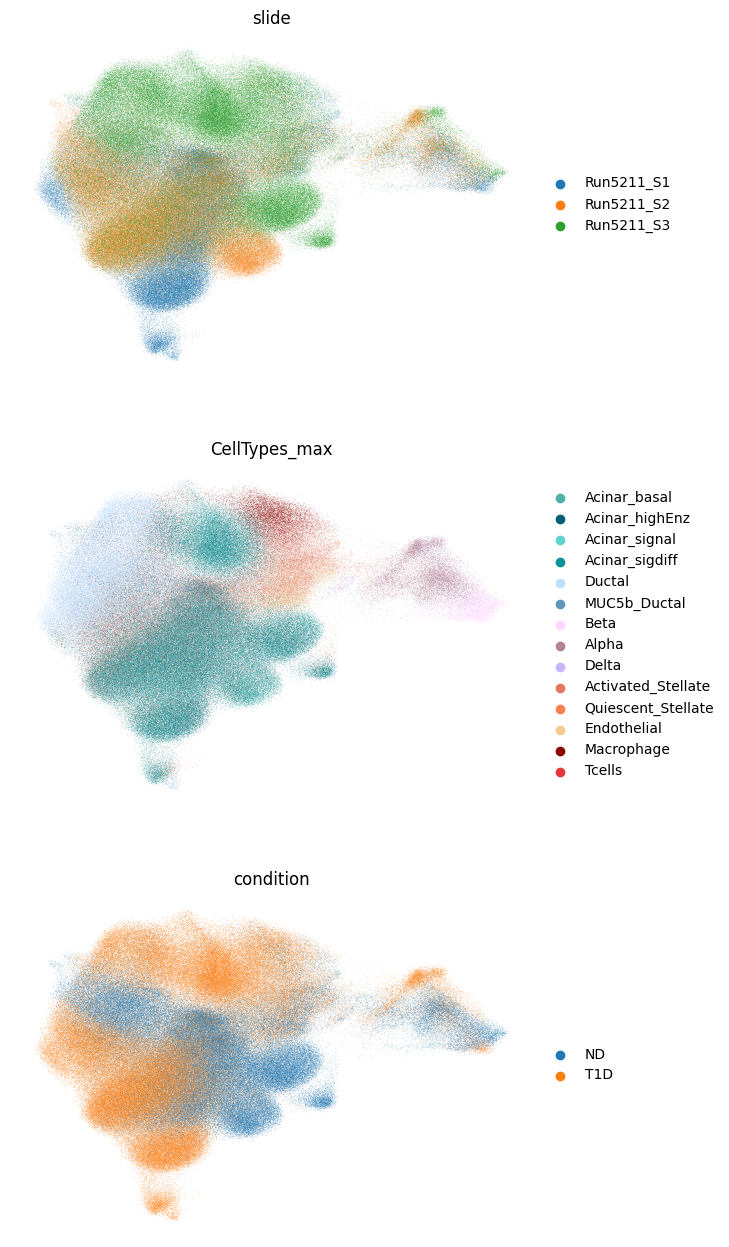

In [51]:
sc.pl.umap(
    adata,
    color=["slide", "CellTypes_max","condition"],
    frameon=False,
    ncols=1,
)

#### scANVI

In [52]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="CellTypes_max",
    unlabeled_category="Unknown",
)

In [53]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-a50f3cc5-4165-5bbc-b58e-02013bf86b4f]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|██████████| 20/20 [20:13<00:00, 56.97s/it, v_num=1, train_loss_step=282, train_loss_epoch=265]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [20:13<00:00, 60.68s/it, v_num=1, train_loss_step=282, train_loss_epoch=265]


In [54]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [60]:
SCANVI_MDE_KEY = "X_scANVI_MDE"
adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCANVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


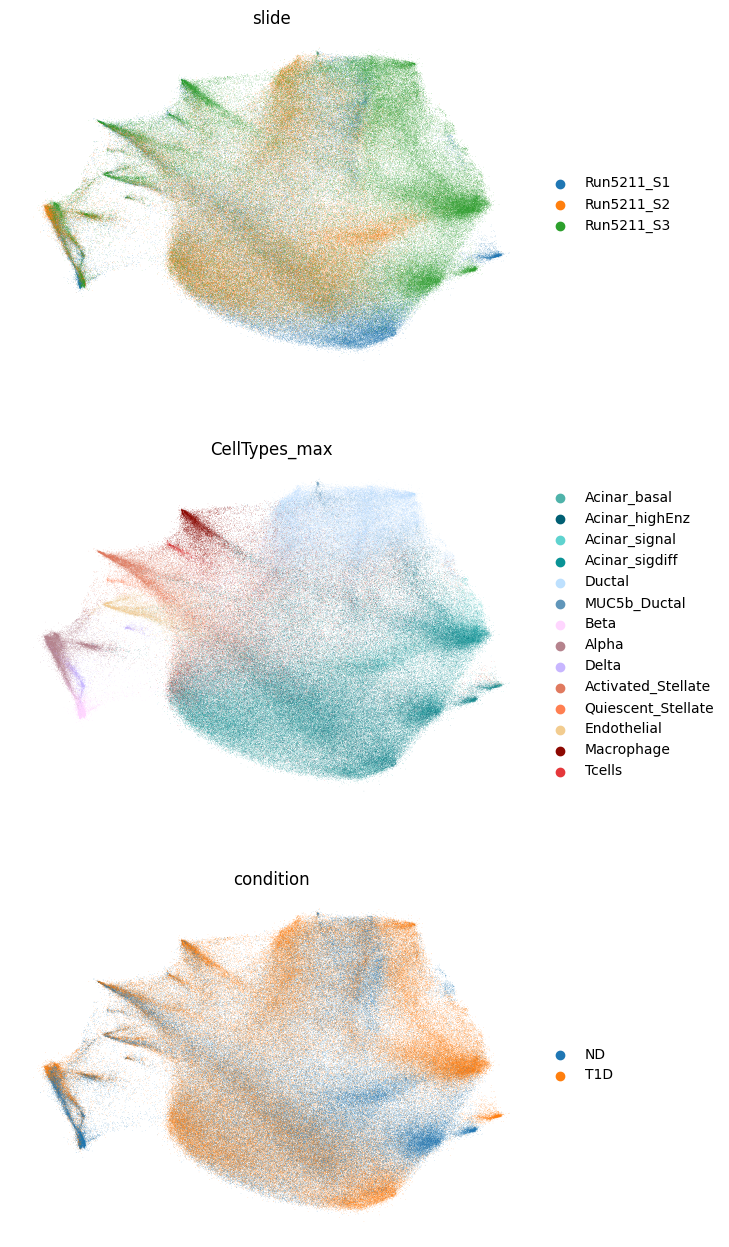

In [61]:
sc.pl.embedding(
    adata,
    basis=SCANVI_MDE_KEY,
    color=["slide", "CellTypes_max","condition"],
    frameon=False,
    ncols=1,
)

In [62]:
adata

AnnData object with n_obs × n_vars = 386727 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'neighbors', 'pca', 'spatial', 'condition_colors', 'slide_colors', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'umap'
    obsm: 'X_pca', '

### Test milo on spatial graphs

#### Prepare for Milo analysis 


In [63]:
## Initialize object for Milo analysis
milo = pt.tl.Milo()
mdata = milo.load(adata)

/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/mudata/_cor

In [64]:
adata.obs_names_make_unique()

When initializing the Milo object, we create a MuData object which will store both the gene expression matrices (```rna``` view) and cell count matrices used for differential abundance analysis (```milo``` view).

In [65]:
mdata

MuData object with n_obs × n_vars = 386727 × 979
  2 modalities
    rna:	386727 x 979
      obs:	'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', '_scvi_batch', '_scvi_labels'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'CellTypes_max_colors', 'cell_type_coarse_colors', 'neighbors', 'pca', 'spatial', 'condition_colors', 'slide_colors', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'umap'
      obsm:	'X_pca', 'X_umap', 'spatial', 'spatial_fov', 'X_scVI', 'X_scANVI', 'X_scANVI_MDE'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    milo:	0 x 0

#### Build kNN graph 

We can use scanpy functions to build a KNN graph. We set the dimensionality and value for k to use in subsequent steps. 

In [114]:
sc.pp.neighbors(mdata["rna"], use_rep=SCANVI_MDE_KEY, n_neighbors=150)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:08:29)


#### Construct neighbourhoods

This step assigns cells to a set of representative neighbourhoods on the KNN graph.

In [115]:
milo.make_nhoods(mdata["rna"], prop=0.1)

The assignment of cells to neighbourhoods is stored as a sparse binary matrix in ```mdata['rna'].obsm```. Here we see that cells have been assigned to 36743 neighbourhoods.

In [116]:
mdata["rna"].obsm["nhoods"]

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 5905617 stored elements and shape (386727, 36816)>

The information on which cells are sampled as index cells of representative neighbourhoods is stored in ```mdata['rna'].obs```, along with the distance of the index to the kth nearest neighbor, which is used later for the SpatialFDR correction.

In [117]:
mdata["rna"][mdata["rna"].obs["nhood_ixs_refined"] != 0].obs[["nhood_ixs_refined", "nhood_kth_distance"]]

,nhood_ixs_refined,nhood_kth_distance
26_1,1,0.036412
38_1,1,0.034995
45_1,1,0.031697
47_1,1,0.035132
59_1,1,0.028647
...,...,...
7221_25,1,0.040718
7224_25,1,0.032624
7225_25,1,0.035195
7231_25,1,0.034089


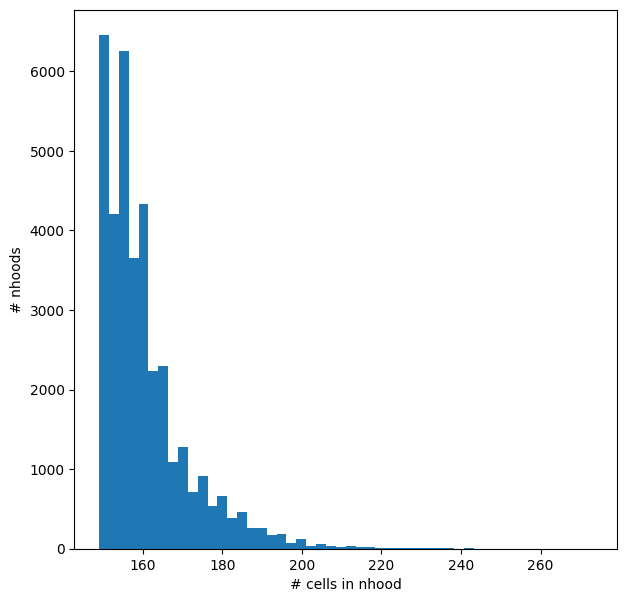

In [118]:
nhood_size = np.array(mdata["rna"].obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=50)
plt.xlabel("# cells in nhood")
plt.ylabel("# nhoods");

#### Count cells in neighbourhoods  

Milo leverages the variation in cell numbers between replicates for the same experimental condition to test for differential abundance. Therefore we have to count how many cells from each sample (in this case the donor - which is encoded by slide) are in each neighbourhood. We need to use the cell metadata saved in ```adata.obs``` and specify which column contains the sample information.

In [119]:
# Create the new 'donor' field by combining 'condition' and 'slide'
mdata["rna"].obs['donor'] = mdata["rna"].obs[['condition', 'slide']].apply(lambda row: f'{row["condition"]}_{row["slide"]}', axis=1)

In [120]:
# Convert the 'donor' field to a categorical data type
mdata["rna"].obs['donor'] = mdata["rna"].obs['donor'].astype('category')

In [121]:
mdata["rna"].obs['donor'].cat.categories

Index(['ND_Run5211_S1', 'ND_Run5211_S2', 'ND_Run5211_S3', 'T1D_Run5211_S1',
       'T1D_Run5211_S2', 'T1D_Run5211_S3'],
      dtype='object')

In [122]:
mdata = milo.count_nhoods(mdata, sample_col="donor")

This function populates the modality milo to mdata.

mdata[‘milo’] is an anndata object where ```obs``` correspond to samples and ```vars``` correspond to neighbourhoods, and where ```.X``` stores the number of cells from each sample counted in a neighbourhood. This count matrix will be used for DA testing.

In [123]:
mdata

MuData object with n_obs × n_vars = 386727 × 979
  2 modalities
    rna:	386727 x 979
      obs:	'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', '_scvi_batch', '_scvi_labels', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'donor'
      var:	'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'CellTypes_max_colors', 'cell_type_coarse_colors', 'neighbors', 'pca', 'spatial', 'condition_colors', 'slide_colors', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'umap', 'nhood_neighbors_key'
      obsm:	'X_pca', 'X_umap', 'spatial', 'spatial_fov', 'X_scVI', 'X_scANVI', 'X_scANVI_MDE', 'nhoods'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    milo:	6 x 36816
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

In [124]:
mdata["milo"]

AnnData object with n_obs × n_vars = 6 × 36816
    var: 'index_cell', 'kth_distance'
    uns: 'sample_col'

### Differential abundance testing with GLM

We are now ready to test for differential abundance in time. The experimental design needs to be specified with R-style formulas.

In [125]:
milo.da_nhoods(mdata, design="~condition")

/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/pertpy/tools/_milo.py:706: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/pertpy/tools/_milo.py:707: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = w[keep_nhoods][o]


In addition, we might want to take into account potential confounders that could affect cell abundances, for example batch effects. We can include confounders in the model using the syntax ~ confounders + condition, where the covariate specified in the last term is always the covariate of interest. 

In [126]:
mdata["milo"].obs

,condition,donor
ND_Run5211_S1,ND,ND_Run5211_S1
ND_Run5211_S2,ND,ND_Run5211_S2
ND_Run5211_S3,ND,ND_Run5211_S3
T1D_Run5211_S1,T1D,T1D_Run5211_S1
T1D_Run5211_S2,T1D,T1D_Run5211_S2
T1D_Run5211_S3,T1D,T1D_Run5211_S3


In [127]:
mdata["milo"].var

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,26_1,0.036412,-1.359573,5.064995,1.347998,0.271373,0.999238,0.999357
1,38_1,0.034995,1.721405,5.258355,0.965566,0.347914,0.999238,0.999357
2,45_1,0.031697,3.009402,5.594992,0.931046,0.356314,0.999238,0.999357
3,47_1,0.035132,0.063932,4.718109,0.006499,0.937266,0.999238,0.999357
4,59_1,0.028647,0.669306,5.500445,0.081804,0.780437,0.999238,0.999357
...,...,...,...,...,...,...,...,...
36811,7221_25,0.040718,0.558776,5.099337,0.188200,0.673208,0.999238,0.999357
36812,7224_25,0.032624,0.984555,4.390081,0.501841,0.494137,0.999238,0.999357
36813,7225_25,0.035195,3.737466,4.420909,2.242769,0.172211,0.999238,0.999357
36814,7231_25,0.034089,3.865734,4.398878,3.222718,0.104300,0.999238,0.999357


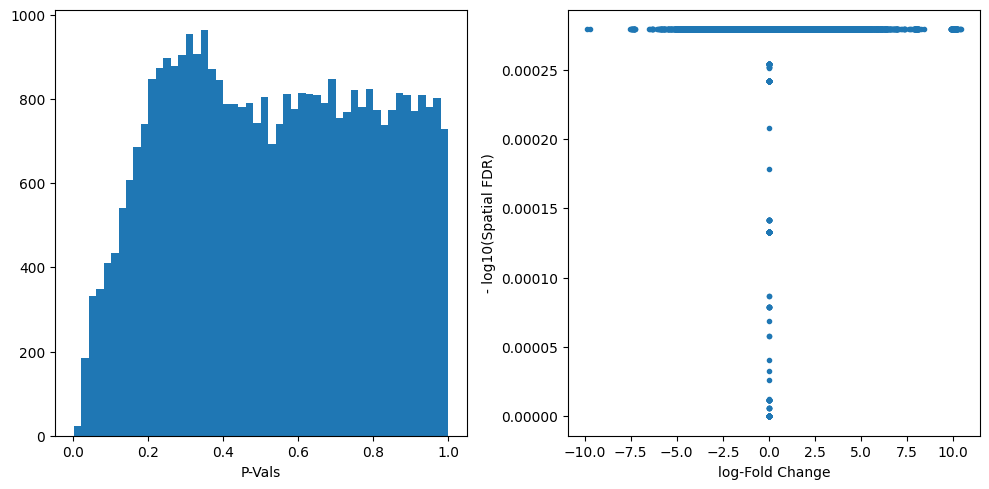

In [128]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10, 5]
plt.subplot(1, 2, 1)
plt.hist(mdata["milo"].var.PValue, bins=50)
plt.xlabel("P-Vals")
plt.subplot(1, 2, 2)
plt.plot(mdata["milo"].var.logFC, -np.log10(mdata["milo"].var.SpatialFDR), ".")
plt.xlabel("log-Fold Change")
plt.ylabel("- log10(Spatial FDR)")
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

#### Visualize results on embedding

In [129]:
milo.build_nhood_graph(mdata)

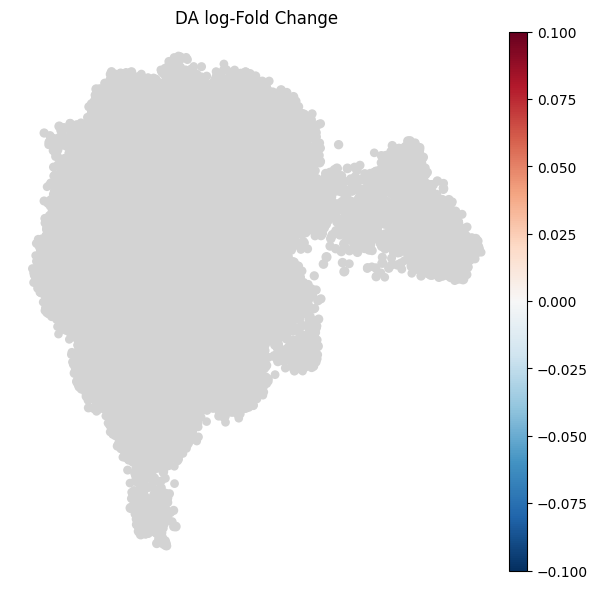

In [130]:
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata,
    alpha=0.1,  ## SpatialFDR level (1%)
    min_size=1,  ## Size of smallest dot
)

#### Visualize results by celltype

In [131]:
milo.annotate_nhoods(mdata, anno_col="CellTypes_max")

Text(0.5, 0, 'celltype fraction')

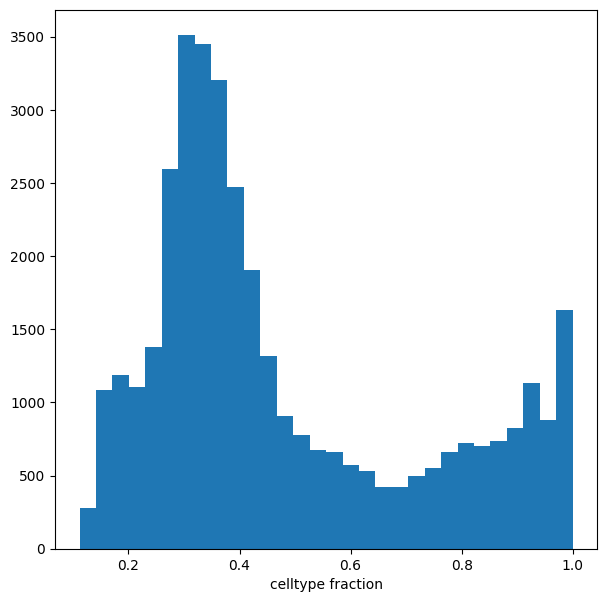

In [132]:
plt.hist(mdata["milo"].var["nhood_annotation_frac"], bins=30)
plt.xlabel("celltype fraction")

/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/pertpy/tools/_milo.py:923: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nhood_adata.obs[[anno_col, "logFC"]].groupby(anno_col).median().sort_values("logFC", ascending=True).index
/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/pertpy/tools/_milo.py:940: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/home/aih/sara.jimenez/miniconda3/envs/pertpy/lib/python3.10/site-packages/pertpy/tools/_milo.py:940: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violi

<Axes: xlabel='logFC', ylabel='nhood_annotation'>

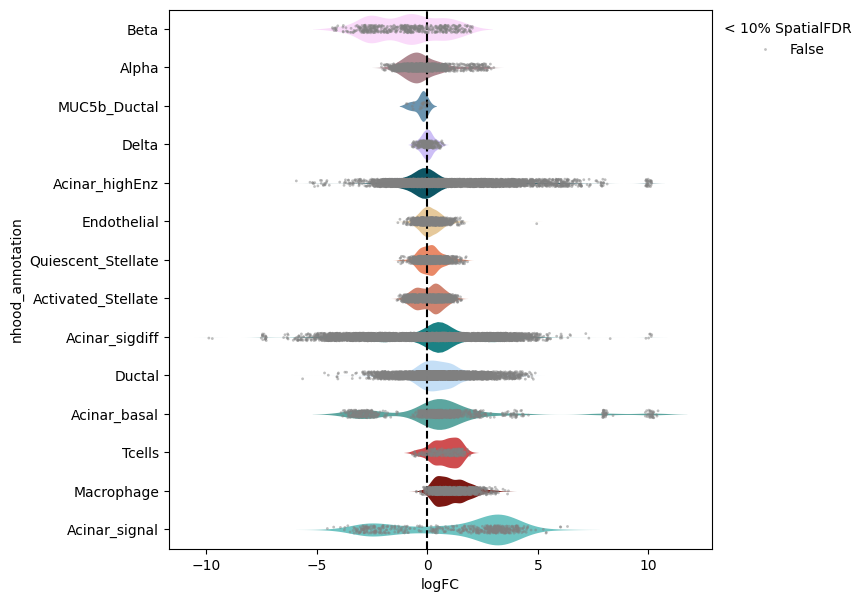

In [133]:
milo.plot_da_beeswarm(mdata, alpha=0.1)

In [134]:
mdata["milo"].var["SpatialFDR"] 

0        0.999357
1        0.999357
2        0.999357
3        0.999357
4        0.999357
           ...   
36811    0.999357
36812    0.999357
36813    0.999357
36814    0.999357
36815    0.999357
Name: SpatialFDR, Length: 36816, dtype: float64

<Axes: xlabel='condition', ylabel='#\xa0cells'>

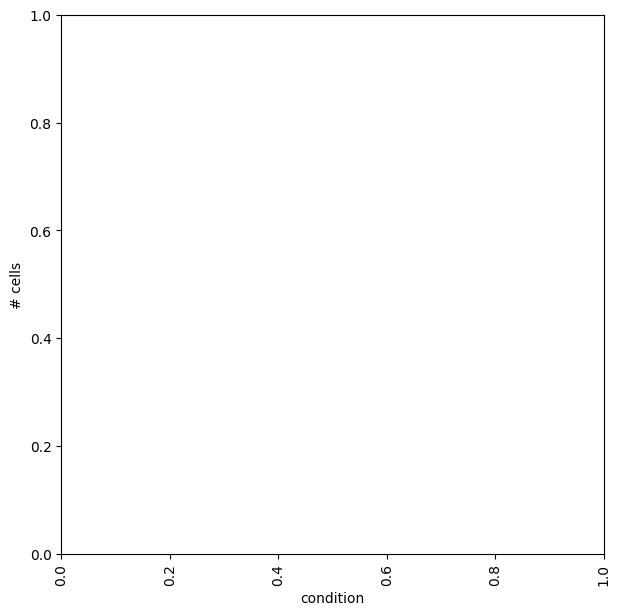

In [135]:
## Get IDs of plasmablast neighbourhood
pl_nhoods = mdata["milo"].var_names[
    (mdata["milo"].var["SpatialFDR"] < 0.1) & (mdata["milo"].var["nhood_annotation"] == "Acinar_signal")
]

## Visualize cell counts by condition (x-axis) and individuals on all neighbourhoods
milo.plot_nhood_counts_by_cond(mdata, test_var="condition", subset_nhoods=pl_nhoods, log_counts=False)

In [136]:
## or one neighbourhood at a time
with matplotlib.rc_context({"figure.figsize": [12, 6]}):
    for i, nh in enumerate(pl_nhoods):
        plt.subplot(2, 5, i + 1)
        milo.plot_nhood_counts_by_cond(mdata, test_var="condition", subset_nhoods=nh, log_counts=False)
        plt.title(f"Nhood {nh}")
    plt.tight_layout()

<Figure size 1200x600 with 0 Axes>